In [21]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [23]:
from transformers import MegatronBertModel, MegatronBertConfig

configuration = MegatronBertConfig()
megatron = MegatronBertModel(configuration)
configuration = megatron.config


In [24]:
megatron

MegatronBertModel(
  (embeddings): MegatronBertEmbeddings(
    (word_embeddings): Embedding(29056, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MegatronBertEncoder(
    (layer): ModuleList(
      (0): MegatronBertLayer(
        (attention): MegatronBertAttention(
          (ln): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (self): MegatronBertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): MegatronBertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )


In [25]:
megatron_lin_1 = megatron.encoder.layer[0].attention.ln.weight[:].detach().numpy()
megatron_self_1 = megatron.encoder.layer[0].attention.self.query.weight[:].detach().numpy()
megatron_pooler_dense = megatron.pooler.dense.weight[:].detach().numpy()
print("megatron_lin_1", megatron_lin_1.shape)
print("megatron_self_1", megatron_self_1.shape)
print("megatron_pooler_dense", megatron_pooler_dense.shape)


megatron_lin_1 (1024,)
megatron_self_1 (1024, 1024)
megatron_pooler_dense (1024, 1024)


In [26]:
from analyze_models import Plot2DMatrix, PlotVectorSizes

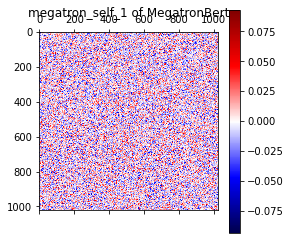

100%|██████████| 1024/1024 [00:03<00:00, 305.11it/s]


There are totally 0 zero elements in this matrix, percentage is 0.0


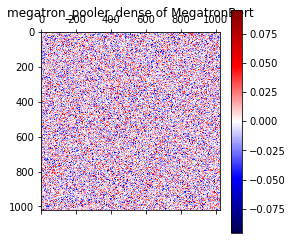

100%|██████████| 1024/1024 [00:04<00:00, 250.47it/s]

There are totally 0 zero elements in this matrix, percentage is 0.0


In [27]:
Plot2DMatrix(megatron_self_1, "megatron_self_1 of MegatronBert", color_map="seismic")
Plot2DMatrix(megatron_pooler_dense, "megatron_pooler_dense of MegatronBert", color_map="seismic")

In [28]:
import torch.nn.utils.prune as prune

## global pruning
parameters_to_prune = (
    (megatron.pooler.dense, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.8,
)

print(
    "Sparsity in dense.weight: {:.2f}%".format(
        100. * float(torch.sum(megatron.pooler.dense.weight == 0))
        / float(megatron.pooler.dense.weight.nelement())
    )
)

Sparsity in dense.weight: 80.00%


In [29]:
comp_megatron_pooler = megatron.pooler.dense.weight[:].detach().numpy()
print("comp_megatron_pooler", comp_megatron_pooler.shape)

comp_megatron_pooler (1024, 1024)


100%|██████████| 1024/1024 [00:02<00:00, 475.26it/s]


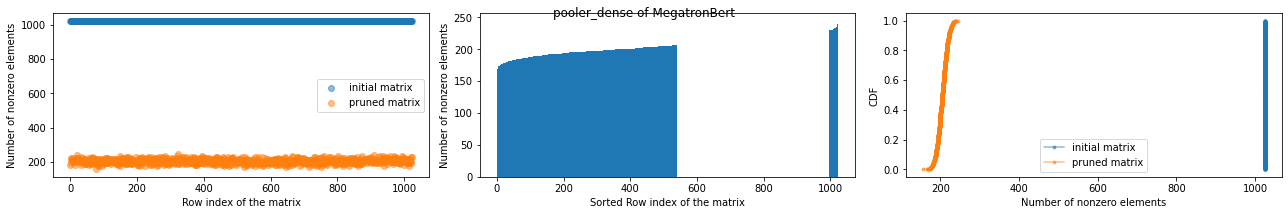

In [30]:
PlotVectorSizes(megatron_pooler_dense, comp_megatron_pooler, "pooler_dense of MegatronBert", plot_two_matrces=True)